In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
import json
from math import floor, log10

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
PLOT = False
PLOTS_DIR = './plots'

In [30]:
if not os.path.isdir(PLOTS_DIR): 
    os.mkdir(PLOTS_DIR)

In [38]:
model = 'txl'
all_models = ['txl', 'gpt', 'bert']
COMPUTE_MEANS = False
PLOT_PAIRPLOTS = False
SORT_BY_FIRST_PC = True
PC_COUNT = 3

In [4]:
non_number_cols = {'sent', 'freq', 'noun', 's_freq', 'p_freq'}

In [5]:
SVA_TASKS = ['Simple', 'SubjRelClause', 'SentComp', 'PP', 'ObjRelClauseThat', 'ObjRelClauseNoThat'] # Leave out ShortVpCoord
RA_TASKS = ['Simple', 'SentComp', 'ObjRelClauseThat', 'ObjRelClauseNoThat']
SENTTYPE_TASKS = {'sv_agreement': SVA_TASKS, 'anaphora': RA_TASKS}
SHORTENED_SENTTYPES = [('SV', 'sv_agreement'), ('RA', 'anaphora')]

In [32]:
def load_and_mean_diffs(model, standardize=True): 
    senttype_dfs = {}
    if not COMPUTE_MEANS: 
        full_df = pd.read_csv('./data/%s_all_means.csv' % (model))
        senttype_dfs['SV'] = pd.read_csv('./data/%s_sv_means.csv' % (model))
        senttype_dfs['RA'] = pd.read_csv('./data/%s_ra_means.csv' % (model))
    else: 
        means = {'sv_agreement': {}, 'anaphora': {}}
        for senttype, tasks in SENTTYPE_TASKS.items(): 
            for task in tasks: 
                differences_filename = '../transformer_evals/%s_%s/differences_data/%s.differences.csv' % (model, senttype, task.lower())
                df = pd.read_csv(differences_filename)
                numbers = df[[c for c in df if c not in non_number_cols]]
                if standardize: 
                    numbers = (numbers-numbers.mean())/(numbers.std())
                s_mean_vals = numbers[[c for c in numbers if c.startswith('s')]].mean(axis=1, numeric_only=None)
                p_mean_vals = numbers[[c for c in numbers if c.startswith('p')]].mean(axis=1, numeric_only=None)
                means[senttype][task] = {}
                means[senttype][task]['s'] = {df['sent'][i]: s_mean_vals[i] for i in range(len(df))}
                means[senttype][task]['p'] = {df['sent'][i]: p_mean_vals[i] for i in range(len(df))}
        full_df = pd.DataFrame()
        full_df['Noun'] = df['sent']
        
        for shortened, senttype in SHORTENED_SENTTYPES: 
            senttype_df = pd.DataFrame()
            senttype_df['Noun'] = full_df['Noun']
            for task in SENTTYPE_TASKS[senttype]: 
                for plurality in ['s', 'p']: 
                    colname = '%s_%s_%s' % (shortened, task, plurality)
                    task_colname = '%s_%s' % (task, plurality)
                    full_df[colname] = full_df['Noun'].map(means[senttype][task][plurality])
                    senttype_df[task_colname] = senttype_df['Noun'].map(means[senttype][task][plurality])
            # senttype_df.drop('Noun', axis=1, inplace=True)
            senttype_df = senttype_df[(senttype_df.T != 0).all()]
            senttype_dfs[shortened] = senttype_df
        full_df = full_df[(full_df.T != 0).all()]
        
        wikitext_freqs = {}
        with open("./word_freqs.json.txt", "r") as f: 
            wikitext_freqs = json.load(f)

        webtext_freqs = {}
        with open("./webtext_word_freqs.json.txt", "r") as f: 
            webtext_freqs = json.load(f)

        wikitext_s_freqs = {word: metadata[2] for word, metadata in wikitext_freqs.items()}
        wikitext_p_freqs = {word: metadata[3] for word, metadata in wikitext_freqs.items()}
        webtext_s_freqs = {word: metadata[2] for word, metadata in webtext_freqs.items()}
        webtext_p_freqs = {word: metadata[3] for word, metadata in webtext_freqs.items()}

        full_df['wikitext_s_freq'] = full_df['Noun'].map(wikitext_s_freqs)
        full_df['wikitext_p_freq'] = full_df['Noun'].map(wikitext_p_freqs)
        full_df['webtext_s_freqs'] = full_df['Noun'].map(webtext_s_freqs)
        full_df['webtext_p_freqs'] = full_df['Noun'].map(webtext_p_freqs)

        save_dfs(full_df, senttype_dfs, model)
    
    return full_df, senttype_dfs

In [10]:
def save_dfs(full_df, senttype_dfs, model): 
    full_df.to_csv('./data/%s_all_means.csv' % (model), index=False)
    senttype_dfs['SV'].to_csv('./data/%s_sv_means.csv' % (model), index=False)
    senttype_dfs['RA'].to_csv('./data/%s_ra_means.csv' % (model), index=False)

In [11]:
def plot_pairplots(full_df, senttype_dfs): 
    sv_pairplot = sns.pairplot(senttype_dfs['SV'])
    an_pairplot = sns.pairplot(senttype_dfs['RA'])
    full_pairplot = sns.pairplot(full_df)
    return full_pairplot, sv_pairplot, an_pairplot

In [12]:
def run_PCA(full_df, n_components=10): 
    dataset = full_df.drop('Noun', axis=1).to_numpy()
    scaler = StandardScaler(with_mean=True, with_std=True)
    dataset = scaler.fit_transform(dataset)
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(dataset)
    return pca, reduced

In [13]:
def print_pc_vars(pca, print_nums=True): 
    print('NonCumulative explained variance: ')
    print(pca.explained_variance_ratio_)
    print('Cumulative explained variance: ')
    for i, val in enumerate(np.cumsum(pca.explained_variance_ratio_)): 
        print("%s%s" % (str(i+1)+': ' if print_nums else '',  str(val)))

In [14]:
def load_and_map_freqs(df, model=None): 
    word_counts = {}
    if model!='gpt': 
        with open("./word_freqs.json.txt", "r") as f: 
            word_counts = json.load(f)
    else: 
        with open("./webtext_word_freqs.json.txt", "r") as f: 
            word_counts = json.load(f)
    freqs_dict = {}
    for word in word_counts: 
        freqs_dict[word] = word_counts[word][4]
    
    df['Frequency'] = df['Noun'].map(freqs_dict)
    return df

In [15]:
def run_pipeline(model): 
    full_df, senttype_dfs = load_and_mean_diffs(model)
    if COMPUTE_MEANS: 
        save_dfs(full_df, senttype_dfs, model)
    if PLOT_PAIRPLOTS: 
        full_pairplot, sv_pairplot, an_pairplot = plot_pairplots(full_df, senttype_dfs)
        if COMPUTE_MEANS: 
            full_pairplot.savefig('%s/%s_full_pairplot.png' % (PLOTS_DIR, model))
            sv_pairplot.savefig('%s/%s_sv_pairplot.png' % (PLOTS_DIR, model))
            an_pairplot.savefig('%s/%s_ra_pairplot.png' % (PLOTS_DIR, model))
    pca, reduced = run_PCA(full_df)
    print_pc_vars(pca)

    reduced_df = pd.DataFrame()
    reduced_df['Noun'] = full_df['Noun']
    for i in range(PC_COUNT): 
        reduced_df['PC%d' % (i+1)] = reduced.T[i]
    
    reduced_df = load_and_map_freqs(reduced_df, model=model)
    if SORT_BY_FIRST_PC: 
        reduced_df.sort_values('PC1', ascending=False, axis=0,inplace=True)
    reduced_df.to_csv('./data/%s_pca.csv' % (model), index=False)
    return reduced_df

In [36]:
something = load_and_mean_diffs('bert', standardize=True)

In [37]:
something

(           Noun  SV_Simple_s  SV_Simple_p  SV_SubjRelClause_s  \
 0    aboriginal    -1.649961     0.139651            1.251214   
 1      absentee    -1.269188    -0.816367           -0.077883   
 2       accuser     1.739283     0.980941           -0.934629   
 3           ace    -0.347751     2.013696           -1.622958   
 4      achiever    -0.831610    -0.615334           -0.658378   
 ..          ...          ...          ...                 ...   
 674      writer     1.028528     0.506512            1.105657   
 675   youngster     1.384456    -0.049114            1.072425   
 676       youth    -1.433160    -1.254263            1.926453   
 677      zombie    -1.273886    -0.688266            0.100462   
 678       zooid    -1.428332    -0.923415            1.254986   
 
      SV_SubjRelClause_p  SV_SentComp_s  SV_SentComp_p   SV_PP_s   SV_PP_p  \
 0             -0.983815      -1.313018      -0.556301 -0.445101  0.112427   
 1             -0.017306      -1.366253      -2.05

In [29]:
something.std()

s    1.0
p    1.0
dtype: float64

In [17]:
something

s         p
0   -1.443039  2.562176
1   -0.976668  2.207902
2    2.708108  2.873933
3    0.151909  3.256643
4   -0.440723  2.282400
..        ...       ...
718  1.837575  2.698124
719  2.273516  2.492225
720 -1.177501  2.045631
721 -0.982422  2.255373
722 -1.171588  2.168234

[723 rows x 2 columns]

In [68]:
full_df, senttype_dfs = load_and_mean_diffs('bert')

In [69]:
full_df

Noun  SV_Simple_s  SV_Simple_p  SV_SubjRelClause_s  \
0    aboriginal    -1.443039     2.562176           -1.286971   
1      absentee    -0.976668     2.207902           -1.423133   
2       accuser     2.708108     2.873933           -1.510050   
3           ace     0.151909     3.256643           -1.580694   
4      achiever    -0.440723     2.282400           -1.479239   
..          ...          ...          ...                 ...   
674      writer     1.837575     2.698124           -1.294098   
675   youngster     2.273516     2.492225           -1.302406   
676       youth    -1.177501     2.045631           -1.213959   
677      zombie    -0.982422     2.255373           -1.403577   
678       zooid    -1.171588     2.168234           -1.284411   

     SV_SubjRelClause_p  SV_SentComp_s  SV_SentComp_p   SV_PP_s   SV_PP_p  \
0              1.072076      -1.273314       2.047132  0.228672  1.424098   
1              1.216793      -1.327606       1.674129  0.649862  1.594059   
2              1.292872      -0.561749       2.073039  1.234530  1.744485   
3              1.407901      -0.850228       2.598845  0.175102  0.773100   
4              1.296409      -0.594763       2.214475  0.252962  1.860593   
..                  ...            ...            ...       ...       ...   
674            1.574924       0.476651       2.212484  0.286515  1.407079   
675            1.042302      -0.859350       1.951414  1.261787  1.666545   
676            1.058721      -0.834491       1.944820  0.289508  1.154102   
677            1.190332      -1.082713       2.559816  0.618771  1.561928   
678            0.999131      -1.346874       2.142290  0.308556  1.600073   

     SV_ObjRelClauseThat_s  ...  RA_SentComp_s  RA_SentComp_p  \
0                -0.409996  ...      -0.156406       2.022834   
1                -1.242724  ...       1.919376       2.245894   
2                -0.196502  ...       2.915073       1.881751   
3                -0.535270  ...       2.123161       1.505828   
4                -0.869010  ...       2.313291       2.157964   
..                     ...  ...            ...            ...   
674              -0.213597  ...       2.837560       2.062908   
675              -0.921650  ...       3.229911       2.037194   
676              -0.969278  ...       1.309143       2.507983   
677              -0.805507  ...       1.825046       2.290146   
678              -0.926738  ...       1.791705       2.119835   

     RA_ObjRelClauseThat_s  RA_ObjRelClauseThat_p  RA_ObjRelClauseNoThat_s  \
0                 0.306480               1.228331                 0.346916   
1                 2.079237               1.169356                 1.591653   
2                 2.242859               0.780182                 2.342129   
3                 1.227988               0.343808                 1.450131   
4                 1.941387               1.434497                 1.408393   
..                     ...                    ...                      ...   
674               2.042533               1.428555                 2.462771   
675               3.153762               1.678902                 2.191847   
676               0.825564               1.010479                 1.057421   
677               1.418223               1.456468                 1.366489   
678               1.560632               1.415386                 1.265495   

     RA_ObjRelClauseNoThat_p  wikitext_s_freq  wikitext_p_freq  \
0                   1.074099              830               72   
1                   1.173753              111                6   
2                   0.922259               39               38   
3                   0.186960             1494              295   
4                   1.234116               25                6   
..                       ...              ...              ...   
674                 1.118527            11195             8004   
675                 1.379774              110              

In [48]:
senttype_dfs['SV']

Noun  Simple_s  Simple_p  SubjRelClause_s  SubjRelClause_p  \
0    aboriginal -1.443039  2.562176        -1.286971         1.072076   
1      absentee -0.976668  2.207902        -1.423133         1.216793   
2       accuser  2.708108  2.873933        -1.510050         1.292872   
3           ace  0.151909  3.256643        -1.580694         1.407901   
4      achiever -0.440723  2.282400        -1.479239         1.296409   
..          ...       ...       ...              ...              ...   
674      writer  1.837575  2.698124        -1.294098         1.574924   
675   youngster  2.273516  2.492225        -1.302406         1.042302   
676       youth -1.177501  2.045631        -1.213959         1.058721   
677      zombie -0.982422  2.255373        -1.403577         1.190332   
678       zooid -1.171588  2.168234        -1.284411         0.999131   

     SentComp_s  SentComp_p      PP_s      PP_p  ObjRelClauseThat_s  \
0     -1.273314    2.047132  0.228672  1.424098           -0.409996   
1     -1.327606    1.674129  0.649862  1.594059           -1.242724   
2     -0.561749    2.073039  1.234530  1.744485           -0.196502   
3     -0.850228    2.598845  0.175102  0.773100           -0.535270   
4     -0.594763    2.214475  0.252962  1.860593           -0.869010   
..          ...         ...       ...       ...                 ...   
674    0.476651    2.212484  0.286515  1.407079           -0.213597   
675   -0.859350    1.951414  1.261787  1.666545           -0.921650   
676   -0.834491    1.944820  0.289508  1.154102           -0.969278   
677   -1.082713    2.559816  0.618771  1.561928           -0.805507   
678   -1.346874    2.142290  0.308556  1.600073           -0.926738   

     ObjRelClauseThat_p  ObjRelClauseNoThat_s  ObjRelClauseNoThat_p  
0              0.836923             -0.220766              0.347605  
1              0.897435             -0.626678              0.277006  
2              0.231591             -0.405741              0.178613  
3              0.650758             -0.463908              0.335644  
4              0.974811             -0.383125              0.395403  
..                  ...                   ...                   ...  
674            1.155130             -0.492153              0.484078  
675            0.875451             -0.344566              0.275550  
676            0.600711             -0.406254              0.182208  
677            0.872149             -0.528259              0.372387  
678            0.985999             -0.426512              0.354231  

[679 rows x 13 columns]

In [28]:
senttype_dfs['SV']

Noun    Simple  SubjRelClause  SentComp        PP  \
0    aboriginal  0.559568      -0.107448  0.386909  0.826385   
1      absentee  0.615617      -0.103170  0.173261  1.121960   
2       accuser  2.791021      -0.108589  0.755645  1.489508   
3           ace  1.704276      -0.086397  0.874308  0.474101   
4      achiever  0.920839      -0.091415  0.809856  1.056778   
..          ...       ...            ...       ...       ...   
674      writer  2.267849       0.140413  1.344567  0.846797   
675   youngster  2.382870      -0.130052  0.546032  1.464166   
676       youth  0.434065      -0.077619  0.555165  0.721805   
677      zombie  0.636475      -0.106623  0.738551  1.090349   
678       zooid  0.498323      -0.142640  0.397708  0.954315   

     ObjRelClauseThat  ObjRelClauseNoThat  
0            0.213464            0.063419  
1           -0.172644           -0.174836  
2            0.017545           -0.113564  
3            0.057744           -0.064132  
4            0.052900            0.006139  
..                ...                 ...  
674          0.470767           -0.004038  
675         -0.023099           -0.034508  
676         -0.184284           -0.112023  
677          0.033321           -0.077936  
678          0.029630           -0.036141  

[679 rows x 7 columns]

In [20]:
run_pipeline('txl')
run_pipeline('gpt')
run_pipeline('bert')

NonCumulative explained variance: 
[0.46625284 0.26360567 0.12127589 0.05717285 0.04157839 0.01521622
 0.01201585 0.01134959 0.00749694 0.00403575]
Cumulative explained variance: 
1: 0.46625283872033246
2: 0.7298585109058809
3: 0.8511344023910874
4: 0.9083072550984944
5: 0.9498856449394708
6: 0.9651018697185176
7: 0.9771177212360457
8: 0.9884673158984967
9: 0.995964251450231
10: 1.0
NonCumulative explained variance: 
[0.41460034 0.27273866 0.1185185  0.06610553 0.04553736 0.03172842
 0.02005924 0.01587487 0.0088413  0.00599577]
Cumulative explained variance: 
1: 0.41460034210709895
2: 0.6873390032148324
3: 0.8058575039426649
4: 0.8719630349157244
5: 0.9175003926414187
6: 0.9492288157216613
7: 0.9692880586588883
8: 0.9851629283578445
9: 0.9940042254224913
10: 1.0000000000000002
NonCumulative explained variance: 
[0.3865446  0.1753531  0.14542723 0.09603432 0.08851249 0.04965
 0.02609371 0.02288728 0.00565033 0.00384694]
Cumulative explained variance: 
1: 0.38654459707252176
2: 0.5618976

Noun       PC1       PC2       PC3  Frequency
133  contemporary  5.710942 -0.243841  0.092779       8305
199           ewe  5.416140 -1.393718 -2.357137        175
287   independent  5.307410 -1.652784  0.323036       9536
252     guerrilla  5.277345 -1.135022 -0.208537        977
210         fauna  5.262775 -0.634420 -0.958100        694
..            ...       ...       ...       ...        ...
167      deserter -4.308824 -1.095682 -0.702621        207
357         moron -4.402242 -0.384427 -0.438175         30
312     kidnapper -4.451367  0.088164  0.229852        124
237       gambler -4.786676  0.269023 -0.095955        262
311           kid -5.377671 -0.987744  0.098371       3955

[679 rows x 5 columns]

# Correlation between all

In [31]:
def load_all_dicts(): 
    full_df_dict = {}
    senttype_dfs_dict = {}
    for model in all_models: 
        full_df, senttype_dfs = load_and_mean_diffs(model)
        full_df_dict[model] = full_df
        senttype_dfs_dict[model] = senttype_dfs
    return full_df_dict, senttype_dfs_dict

In [32]:
def get_nouns_list(full_df_dict): 
    nouns_sets = [set(full_df_dict[model]['Noun']) for model in all_models]
    total_set = nouns_sets[0]
    for i in range(1, len(nouns_sets)): 
        total_set = total_set.intersection(nouns_sets[i])
    return list(total_set)

In [33]:
def rename_df_dicts(full_df_dict): 
    if 'gpt' in full_df_dict: 
        full_df_dict['gpt2'] = full_df_dict['gpt']
        full_df_dict.pop('gpt')
    return full_df_dict

In [34]:
def run_correlation_pipeline(): 
    full_df_dict, senttype_dfs_dict = load_all_dicts()
    total_nouns_list = get_nouns_list(full_df_dict)
    full_df_dict = rename_df_dicts(full_df_dict)
    print(len(total_nouns_list))

    df = pd.DataFrame()
    df['Noun'] = total_nouns_list
    for model in full_df_dict: 
        model_suffix = '_%s' % (model)
        column_names = [c+model_suffix if c!='Noun' else c for c in full_df_dict[model].columns]
        full_df_dict[model].columns = column_names
        # print(df.head())
        df = df.join(full_df_dict[model].set_index('Noun'), on='Noun', rsuffix=model_suffix, how='left')
    
    df = df[(df.T != 0).all()]
    return df

In [35]:
def order_feature_importance(pca, feature_names, top_k_features=None): 
    if top_k_features is None: 
        top_k_features = pca.components_.shape[1]
    top_features = np.array([[feature_names[argind] for argind in np.argsort(np.abs(pca.components_[i]))[::-1][:top_k_features]] for i in range(pca.components_.shape[0])])
    top_contributions = np.array([[abs(pca.components_[i, argind]) for argind in np.argsort(np.abs(pca.components_[i]))[::-1][:top_k_features]] for i in range(pca.components_.shape[0])])
    features_df = pd.DataFrame({('PC %d' % (i+1)): np.array([('%s - %f' % (top_features[i, j], top_contributions[i,j])) for j in range(top_features.shape[1])])  for i in range(top_features.shape[0])})
    return features_df

In [36]:
def save_feature_importance_df(models, df, pca, top_k_features=None): 
    features_df = order_feature_importance(pca, df.columns[1:], top_k_features=top_k_features)
    features_df.to_csv('pca_top_features/%s_pca_top_features.csv' % ('-'.join(models)))

In [29]:
all_models_models = [['txl'], ['gpt'], ['bert'], ['gpt', 'txl'], ['gpt', 'bert'], ['bert', 'txl'], ['gpt', 'bert', 'txl']]
for i in range(len(all_models_models)): 
    all_models = all_models_models[i]
    df = run_correlation_pipeline()
    pca, reduced = run_PCA(df, n_components=10*len(all_models))
    print(all_models)
    if True: 
        print_pc_vars(pca, print_nums=False)
    if False: 
        save_feature_importance_df(all_models, df, pca)

870
['txl']
NonCumulative explained variance: 
[0.46625284 0.26360567 0.12127589 0.05717285 0.04157839 0.01521622
 0.01201585 0.01134959 0.00749694 0.00403575]
Cumulative explained variance: 
0.46625283872033235
0.7298585109058808
0.8511344023910875
0.9083072550984945
0.9498856449394709
0.9651018697185177
0.9771177212360457
0.9884673158984967
0.995964251450231
1.0
663
['gpt']
NonCumulative explained variance: 
[0.41460034 0.27273866 0.1185185  0.06610553 0.04553736 0.03172842
 0.02005924 0.01587487 0.0088413  0.00599577]
Cumulative explained variance: 
0.4146003421070991
0.6873390032148325
0.8058575039426648
0.8719630349157241
0.9175003926414185
0.9492288157216611
0.9692880586588881
0.9851629283578442
0.9940042254224911
1.0
679
['bert']
NonCumulative explained variance: 
[0.3865446  0.1753531  0.14542723 0.09603432 0.08851249 0.04965
 0.02609371 0.02288728 0.00565033 0.00384694]
Cumulative explained variance: 
0.38654459707252137
0.5618976961473541
0.7073249226859105
0.8033592475568903

In [37]:
def draw_corr_plot_diag(df, titles, savename=None): 
    def metrics(x, y, ax):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        rho_label = 'r = %s' % (str(round(r_value, 2)))
        ax.annotate(rho_label, xy = (0.02, 0.95), size = 16, xycoords = ax.transAxes)
        p_label = 'p = %.1g' % p_value
        ax.annotate(p_label, xy = (0.02, 0.90), size = 16, xycoords = ax.transAxes)

    fig, big_axes = plt.subplots(figsize=(100, 30) , nrows=3, ncols=1) 

    for row, big_ax in enumerate(big_axes, start=1):
        big_ax.set_title(titles[row], fontsize=20)

        # Turn off axis lines and ticks of the big subplot 
        # obs alpha is 0 in RGBA string!
        big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
        # removes the white frame
        big_ax._frameon = False
    # fig.suptitle(titles[0], fontsize=40)

    i = 0
    # fig, ax = plt.subplots(3,10, figsize=(100,30))
    for model1, model2, color in [('gpt2', 'bert', 'r'), ('gpt2', 'txl', 'g'), ('bert', 'txl', 'b')]:
        for shortened, senttype in SHORTENED_SENTTYPES: 
            category = shortened
            if category=='SV': 
                category = 'SVA'
            for task in SENTTYPE_TASKS[senttype]: 
                i += 1
                ax = fig.add_subplot(3,10,i)
                model1_task = f'{shortened}_{task}_{model1}'
                model2_task = f'{shortened}_{task}_{model2}'
                sns.regplot(x=model1_task, y=model2_task, data=df, ax=ax, color=color)
                metrics(df[model1_task], df[model2_task], ax)
                ax.set_title(f'{category} {task}')
                
    fig.set_facecolor('w')
    plt.tight_layout()
    if savename is not None: 
        plt.savefig(savename)

In [48]:
MODEL_LABELS = {'txl': 'Transformer-XL', 'bert': 'BERT', 'gpt': 'GPT-2'}
TASK_LABELS = {
    'SV_Simple_s': 'Simple (s)', 
    'SV_Simple_p': 'Simple (p)', 
    'SV_SubjRelClause_s': 'Subj. RC (s)', 
    'SV_SubjRelClause_p': 'Subj. RC (p)', 
    'SV_SentComp_s': 'Sent. Comp. (s)', 
    'SV_SentComp_p': 'Sent. Comp. (p)', 
    'SV_PP_s': 'PP (s)', 
    'SV_PP_p': 'PP (p)', 
    'SV_ObjRelClauseThat_s': 'Obj. RC [That] (s)', 
    'SV_ObjRelClauseThat_p': 'Obj. RC [That] (p)', 
    'SV_ObjRelClauseNoThat_s': 'Obj. RC [No That] (s)', 
    'SV_ObjRelClauseNoThat_p': 'Obj. RC [No That] (p)', 
    'RA_Simple_s': 'Simple (s)', 
    'RA_Simple_p': 'Simple (p)', 
    'RA_SentComp_s': 'Sent. Comp. (s)', 
    'RA_SentComp_p': 'Sent. Comp. (p)', 
    'RA_ObjRelClauseThat_s': 'Obj. RC [That] (s)', 
    'RA_ObjRelClauseThat_p': 'Obj. RC [That] (p)', 
    'RA_ObjRelClauseNoThat_s': 'Obj. RC [No That] (s)', 
    'RA_ObjRelClauseNoThat_p': 'Obj. RC [No That] (p)', 
}

In [67]:
def plot_main_body_frequency_plot(savefig = False, txl_wikitext=True, bert_wikitext=True, gpt_wikitext=False, plot_sva=True, plot_ra=True): 
    def metrics(x, y, ax):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        rho_label = 'r = %s' % (str(round(r_value, 2)))
        ax.annotate(rho_label, xy = (0.02, 0.95), size = 16, xycoords = ax.transAxes)
        p_label = 'p = %.1g' % p_value
        ax.annotate(p_label, xy = (0.02, 0.90), size = 16, xycoords = ax.transAxes)

    plotting_both = plot_sva and plot_ra

    task_labels = {}
    if plotting_both: 
        for task, label in TASK_LABELS.items(): 
            task_type = 'SVA' if task.startswith('SV') else 'RA'
            task_labels[task] = f'{label} ({task_type})'
    else: 
        task_labels = TASK_LABELS

    # Load the frequency counts
    freqs = {}
    with open("./word_freqs.json.txt", "r") as f: 
        freqs = json.load(f)

    webtext_freqs = {}
    with open("./webtext_word_freqs.json.txt", "r") as f: 
        webtext_freqs = json.load(f)
    
    fig, ax = plt.subplots(figsize=(30, 10) , nrows=1, ncols=3) 
    plt.suptitle("Noun Frequency vs. Model Performance", fontsize=26)

    all_models = ['txl', 'bert', 'gpt']
    
    # all wikitext or webtext
    all_wikitext = txl_wikitext and bert_wikitext and gpt_wikitext
    all_webtext = (not txl_wikitext) and (not bert_wikitext) and (not gpt_wikitext)

    for i, model in enumerate(all_models): 
        full_df, senttype_dfs = load_and_mean_diffs(model)
        df = full_df[[c for c in full_df.columns if (plot_ra and c.startswith('RA') or (plot_sva and c.startswith('SV')))]]
        df['sent'] = full_df['Noun']
        if i==0: 
            if txl_wikitext: 
                df['s_freq'] = [freqs[x][2] for x in df['sent']]
                df['p_freq'] = [freqs[x][3] for x in df['sent']]
                df['freq'] = [freqs[x][4] for x in df['sent']]
            else: 
                df['s_freq'] = [webtext_freqs[x][2] for x in df['sent']]
                df['p_freq'] = [webtext_freqs[x][3] for x in df['sent']]
                df['freq'] = [webtext_freqs[x][4] for x in df['sent']]
        elif i==1: 
            if bert_wikitext: 
                df['s_freq'] = [freqs[x][2] for x in df['sent']]
                df['p_freq'] = [freqs[x][3] for x in df['sent']]
                df['freq'] = [freqs[x][4] for x in df['sent']]
            else: 
                df['s_freq'] = [webtext_freqs[x][2] for x in df['sent']]
                df['p_freq'] = [webtext_freqs[x][3] for x in df['sent']]
                df['freq'] = [webtext_freqs[x][4] for x in df['sent']]
        elif i==2: 
            if gpt_wikitext: 
                df['s_freq'] = [freqs[x][2] for x in df['sent']]
                df['p_freq'] = [freqs[x][3] for x in df['sent']]
                df['freq'] = [freqs[x][4] for x in df['sent']]
            else: 
                df['s_freq'] = [webtext_freqs[x][2] for x in df['sent']]
                df['p_freq'] = [webtext_freqs[x][3] for x in df['sent']]
                df['freq'] = [webtext_freqs[x][4] for x in df['sent']]

        colors = {
            'SV_Simple_s': 'lightcoral', 
            'SV_Simple_p': 'salmon', 
            'SV_SubjRelClause_s': 'sandybrown', 
            'SV_SubjRelClause_p': 'chocolate', 
            'SV_SentComp_s': 'antiquewhite', 
            'SV_SentComp_p': 'blanchedalmond', 
            'SV_PP_s': 'goldenrod', 
            'SV_PP_p': 'darkgoldenrod', 
            'SV_ObjRelClauseThat_s': 'greenyellow', 
            'SV_ObjRelClauseThat_p': 'lawngreen', 
            'SV_ObjRelClauseNoThat_s': 'mediumspringgreen', 
            'SV_ObjRelClauseNoThat_p': 'aquamarine', 
            'RA_Simple_s': 'orangered', 
            'RA_Simple_p': 'red', 
            'RA_SentComp_s': 'orange', 
            'RA_SentComp_p': 'darkorange', 
            'RA_ObjRelClauseThat_s': 'palegreen', 
            'RA_ObjRelClauseThat_p': 'lightgreen', 
            'RA_ObjRelClauseNoThat_s': 'cyan',
            'RA_ObjRelClauseNoThat_p': 'darkturquoise',
        }

        not_plot_cols = {'freq', 'sent', 's_freq', 'p_freq'}

        to_graph = [col_name for col_name in df.columns if col_name not in not_plot_cols]

        ax[i].set_xscale('log')
        ax[i].tick_params(axis='both', which='major', labelsize=18)
        
        # border width
        for axis in ['top','bottom','left','right']:
            ax[i].spines[axis].set_linewidth(1.5)
        
        # ax[i].set_xlim(1, 10e5)
        ax[i].set_title("%s" % (MODEL_LABELS[model]), fontsize=30)
        total_x = pd.Series([])
        total_y = pd.Series([])
        for struct in to_graph: 
            x = df['freq']
            y = df[struct]
            total_x = total_x.append(x)
            total_y = total_y.append(y)
            ax[i].scatter(x, y, label=task_labels[struct], s=2, color=colors[struct])
            
        sns.regplot(x=total_x, y=total_y, ax=ax[i], color='g', logx=True, scatter_kws={'alpha':0})
        metrics(total_x, total_y, ax[i])

        xlabel_fontsize = 25
        if i==0: 
            ax[i].set_ylabel("Model Performance", fontsize=28)
            if txl_wikitext:
                if not all_wikitext:
                    ax[i].set_xlabel("WikiText-103 Frequency", fontsize=xlabel_fontsize)
            elif not all_webtext: 
                ax[i].set_xlabel("WebText Frequency", fontsize=xlabel_fontsize)
        elif i==1: 
            if bert_wikitext: 
                ax[i].set_xlabel("WikiText-103 Frequency", fontsize=xlabel_fontsize)
            else: 
                ax[i].set_xlabel("WebText Frequency", fontsize=xlabel_fontsize)
                
            # legend    
            ax[i].legend(loc = 'upper center', bbox_to_anchor = (-0.25, -0.65, 1.5, 0.5),
                         ncol = 4, prop = {'size': 12 if plotting_both else 22}, mode = "expand", markerscale = 4,
                         edgecolor = "black")
        elif i==2: 
            if gpt_wikitext:
                if not all_wikitext:
                    ax[i].set_xlabel("WikiText-103 Frequency", fontsize=xlabel_fontsize)
            elif not all_webtext: 
                ax[i].set_xlabel("WebText Frequency", fontsize=xlabel_fontsize)
                    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if savefig:
        tasks_file_suffix = ''
        if plot_sva: 
            tasks_file_suffix +='_sva'
        if plot_ra: 
            tasks_file_suffix += '_ra'

        if txl_wikitext and bert_wikitext:
            if gpt_wikitext:
                plt.savefig(f'{PLOTS_DIR}/main_body_freq_plot_wikitext{tasks_file_suffix}.png')
            else:
                plt.savefig(f'{PLOTS_DIR}/main_body_freq_plot_mixed{tasks_file_suffix}.png')
        elif all_webtext:
            plt.savefig(f'{PLOTS_DIR}/main_body_freq_plot_webtext{tasks_file_suffix}.png')

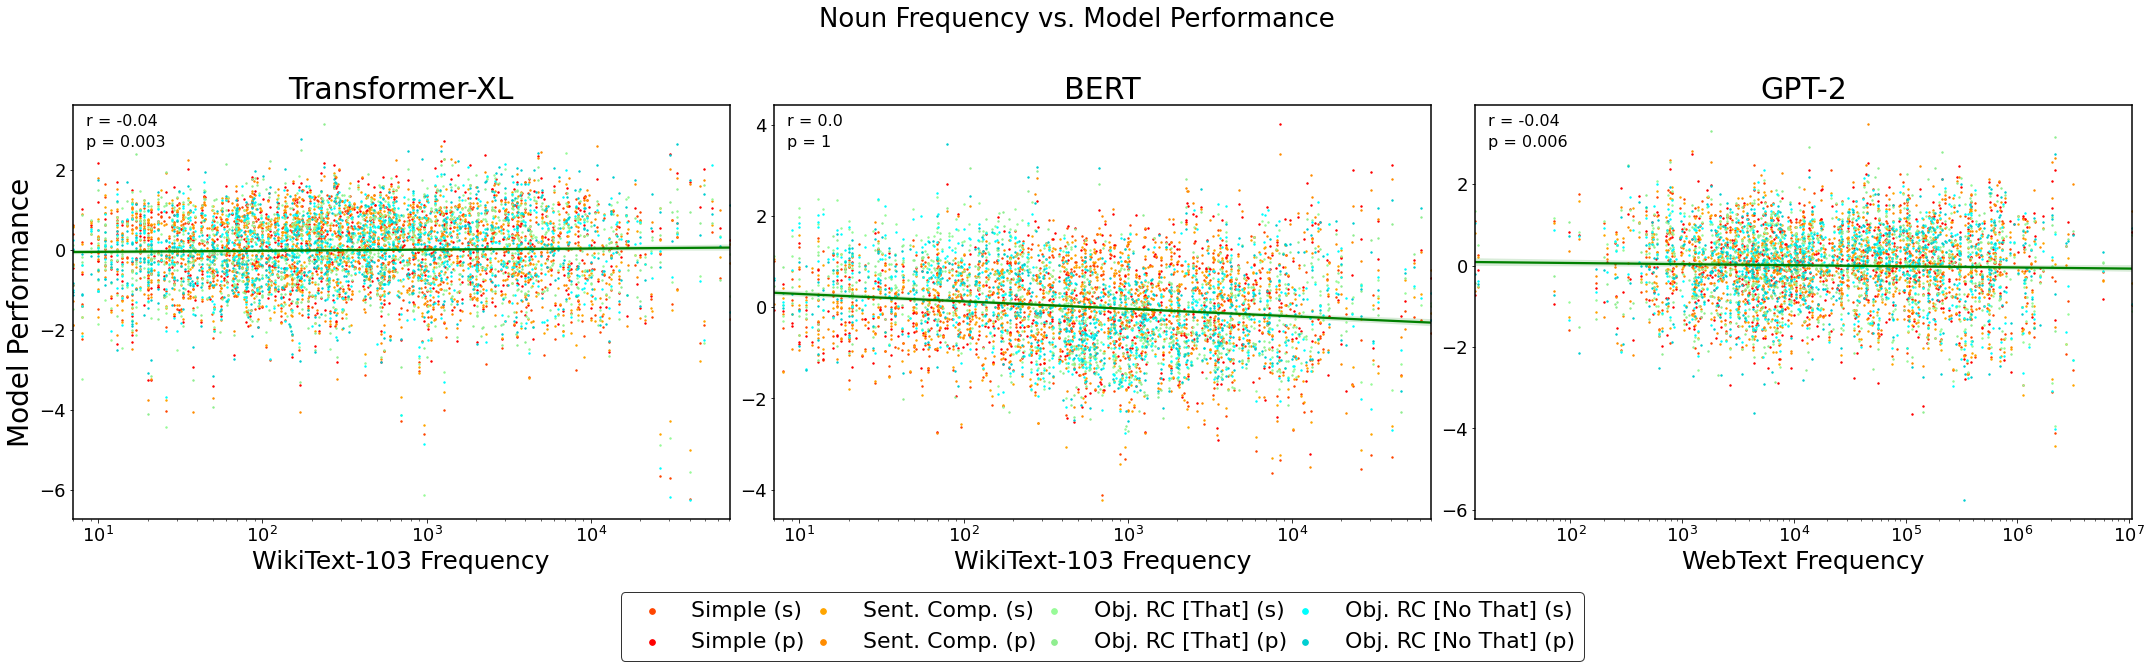

In [71]:
plot_main_body_frequency_plot(savefig=True, plot_sva=False, plot_ra=True)